# Analyse  MNIST structure using Variance-covariance matrix

- Assume distribution of images in image-cluster for each number can be approximated by multivariate normal distribution in (28*28=) 784-dimensional space
- On this assumtion, I'd like to seek a formula of probability distribution function of each image-cluster


- Assume pixel value of image $z = (z_1, z_2, ..., z_n)^T$ is determined by random variable $Z = (Z_1, Z_2, ..., Z_n)^T$


- Assume there is relationship between random variable $Z$ and $X$ s.t. $Z = A X + \mu$
  - $A$ is n*n matrix $A = (A_{ij})$
  - $X$ is random variable $X = (X_1, X_2, ..., X_n)^T$ 
  - $\mu$ is vector  $\mu = (\mu_1, \mu_2, ..., \mu_n)$
  - $X_i$ has probability density function $N(0,1)$, so,
   - probability density function of $X$ is  
     $f(x_1, ..., x_n) = \prod\limits_{i=1}^{n}{1 \over {\sqrt{2 \pi}}} exp(-{x_i^2 \over 2}) = {1 \over {\sqrt{2 \pi}}^n} exp(- \sum\limits_{i=1}^{n}{x_i^2 \over 2}) = {1 \over {\sqrt{2 \pi}}^n} exp(- {1 \over 2}x^T x)$
   - where variable $x = (x_1, x_2, ..., x_n)^T$ determined by random variable $X$


- Temporarily assume $A^{-1}$ exists 
 - So, $X = A^{-1}(Z - \mu)$
 - So, $d x_1 d x_2 ... d x_n = det(A^{-1}) d z_1 d z_2 ... d z_n$
 - So, $f(x_1, ..., x_n)d x_1 ... d x_n \\
    = {1 \over {\sqrt{2 \pi}}^n} exp(- {1 \over 2}x^T x) d x_1 d x_2 ... d x_n \\ 
    = {1 \over {\sqrt{2 \pi}}^n} exp(- {1 \over 2} \{A^{-1}(Z - \mu)\}^T \{A^{-1}(Z - \mu)\}) det(A^{-1}) d z_1 d z_2 ... d z_n \\
    = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A^T)^{-1} (A)^{-1} (Z - \mu)) ) d z_1 d z_2 ... d z_n \\
    = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A A^T)^{-1} (Z - \mu)) ) d z_1 d z_2 ... d z_n $
 - So, for probability density function $g(z_1, ..., z_n)$ of Z : 
   $g(z_1, ..., z_n)d z_1 d z_2 ... d z_n = f(x_1, ..., x_n)d x_1 ... d x_n \\
     = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A A^T)^{-1} (Z - \mu)) ) d z_1 d z_2 ... d z_n $ 
 - So, $g(z_1, ..., z_n) = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A A^T)^{-1} (Z - \mu)) ) $


- BTW, $A A^T$ (= $\Sigma$) can be computed from distribution of Z :
 - $E[Z] = E[A X + \mu] = A E[X] + \mu = 0 + \mu = \mu$
 - $V[Z] = E[(Z - \mu)^T (Z - \mu)] = E[(A X)^T (A X)] = E[(A X) (A X)^T]^T = E[A X X^T A^T]^T \\
    = (A E[X X^T] A^T)^T = (A (V[X] + E[X]) A^T)^T = (A (1 + 0) A^T)^T = (A A^T)^T = A A^T$
 - So, $A A^T$ (= $\Sigma$) can be numerically calculated as Variance-covariance matrix of Z: $V[Z] $ 


- When  $A^{-1}$ DOES NOT exists
 - $\Sigma$ can be numerically calculated as Variance-covariance matrix of Z: $V[Z] $ 
 - I'd like to calucate $A$ s.t. $A A^T = \Sigma$
 - $A$ can be caluculate as follows:
 - Calculate singular value decomposition s.t. $U s V = \Sigma$ where U, V:unitary, s:diagonal(singular values)
 - $A$ is calculated as $A = U r V$ where $r = s^{1/2}$

# Preparation

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

import scipy
import scipy.stats

In [2]:
# print statistics of array and display array as image

def print_stat(a, str, show_image=True):
    print(str, ": shape=", a.shape, "min=", np.min(a), "max=", np.max(a), "mean=", np.mean(a),
          "std=", np.std(a), "rank=", np.linalg.matrix_rank(a), end=" ")
    if len(a.shape) <= 1:
        print()
        return
    if a.shape[0] == a.shape[1]:
        print("det=", np.linalg.det(a))
    else:
        print()
    if show_image:
        plt.imshow(a, interpolation="none")
        plt.colorbar()
        plt.show()

In [3]:
# extract base rows of matrix

def extract_base(a, threshold):
    n = len(a)
    
    i1 = -1
    for i in range(n):
        b1 = a[:,i]
        if np.max(np.abs(b1)) > threshold:
            i1 = i
            break
    if i1 == -1:
        print("ERROR: a is almost zero")
        return None, None, None
    print("extract_base(threshold=", threshold, ") : n=", n, "i1=", i1, "max=", np.max(a[:,i1]))
    
    bindex = [i1]
    b = a[:,i1][:,None]
    rank = 1
    for i in range(i1+1, n):
        nb = a[:,i]
        if np.max(np.abs(nb)) < threshold:
            continue
        ba = np.hstack((b, nb[:,None]))
        if np.linalg.matrix_rank(ba) > rank:
            bindex.append(i)
            b = ba
            rank += 1
    bindex = np.array(bindex)
    # print("rank=", rank)
    # print("bindex=", bindex)
    # print("b="); print(b) 

    return b, bindex, rank

In [4]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/g3doc/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# get sample data

num_all_sample = 50000
x_sample, y_sample = mnist.train.next_batch(num_all_sample)

# shift and scale x_sample [0,1.0] => [-0.5, 0.5]
x_sample = (x_sample - 0.5) * 1.0

x_sample_of_chars = []
for char in range(10):
    index = np.arange(num_all_sample)[y_sample[:,char] == 1]
    x_sample_of_char = x_sample[index]
    x_sample_of_chars.append(x_sample_of_char)

centers : shape= (10, 784) min= -0.5 max= 0.464928 mean= -0.368466 std= 0.20383 rank= 10 


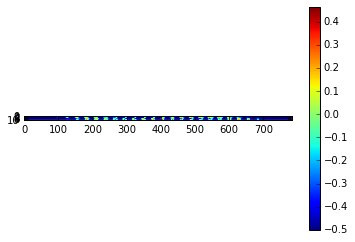

In [6]:
# Calculate centers of image-clusters of 0..9

centers = []
for i in range(10):
    x_sample = x_sample_of_chars[i]
    center = np.average(x_sample, axis=0)
    centers.append(center)
centers = np.array(centers)
print_stat(centers, "centers")

# Calculate and check variance-covariance matrix and A

In [7]:
# Calculate Variance-covariance matrix for each image-cluster
# Result: A * A.T = cov (max error < 2.08616e-07 )

As = []
for i in range(10):
    z = x_sample_of_chars[i]
    n = len(z)
    z = z.T
    u = centers[i]
    print("i=", i, " n=", n)
    
    # Calculate Variance-covariance matrix
    z0 = z - u[:, None]
#    print_stat(z0, "z0")
    cov = np.dot(z0, z0.T)/n
    print_stat(cov, "cov", show_image=False)

    # Calculate A from Variance-covariance matrix
    U, s, V = np.linalg.svd(cov, full_matrices=False)
    r = np.sqrt(s)
    A = np.dot(np.dot(U, np.diag(r)), V)
#    print_stat(A, "A")
    As.append(A)

    # check if A * A.T = cov
    print("max(abs(A * A.T - cov))=", np.max(np.max(np.dot(A, A.T) - cov)))
    print()


i= 0  n= 4955
cov : shape= (784, 784) min= -0.120548 max= 0.197069 mean= 0.00181056 std= 0.01616 rank= 415 det= 0.0
max(abs(A * A.T - cov))= 1.78814e-07

i= 1  n= 5649
cov : shape= (784, 784) min= -0.131593 max= 0.199833 mean= 0.000486891 std= 0.0113572 rank= 274 det= 0.0
max(abs(A * A.T - cov))= 1.04308e-07

i= 2  n= 4977
cov : shape= (784, 784) min= -0.11149 max= 0.199398 mean= 0.00146158 std= 0.0125346 rank= 477 det= 0.0
max(abs(A * A.T - cov))= 2.08616e-07

i= 3  n= 5129
cov : shape= (784, 784) min= -0.114131 max= 0.193089 mean= 0.00146453 std= 0.0117872 rank= 451 det= 0.0
max(abs(A * A.T - cov))= 2.08616e-07

i= 4  n= 4808
cov : shape= (784, 784) min= -0.110217 max= 0.192718 mean= 0.00102147 std= 0.0107976 rank= 457 det= 0.0
max(abs(A * A.T - cov))= 1.49012e-07

i= 5  n= 4529
cov : shape= (784, 784) min= -0.100656 max= 0.192863 mean= 0.00137638 std= 0.0138306 rank= 441 det= 0.0
max(abs(A * A.T - cov))= 1.49012e-07

i= 6  n= 4935
cov : shape= (784, 784) min= -0.108423 max= 0.192206

# Generate images from A and centers

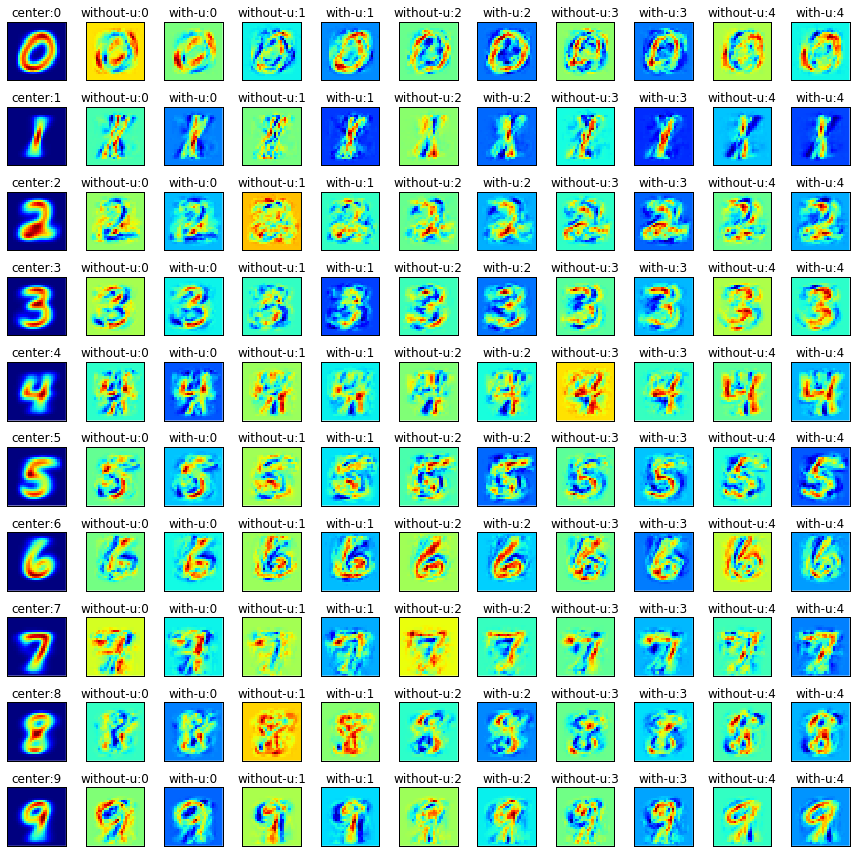

In [8]:
# Generate images from A and centers

cols = 10
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(10, (cols + 1), (cols + 1)*i + 1)
    plt.imshow(centers[i].reshape(28, 28), interpolation="none")
    plt.title("center:"+str(i))
    plt.xticks([])
    plt.yticks([])
    
    A = As[i]
    u = centers[i][:, None]

    for j in range(5):
        plt.subplot(10, (cols + 1), (cols + 1)*i + j*2 + 2)
        x = np.random.standard_normal((784, 1))
        x = np.average(x, axis=1)
        x = x[:, None]

        d = np.dot(A, x) # + u
        img = d.reshape((28, 28))
        plt.subplot(10, (cols + 1), (cols + 1)*i + j*2 + 2)
        plt.imshow(img, interpolation="none")
        plt.title("without-u:"+str(j))
        plt.xticks([])
        plt.yticks([])

        d = np.dot(A, x) + u
        img = d.reshape((28, 28))
        plt.subplot(10, (cols + 1), (cols + 1)*i + j*2 + 1 +  2)
        plt.imshow(img, interpolation="none")
        plt.title("with-u:"+str(j))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()

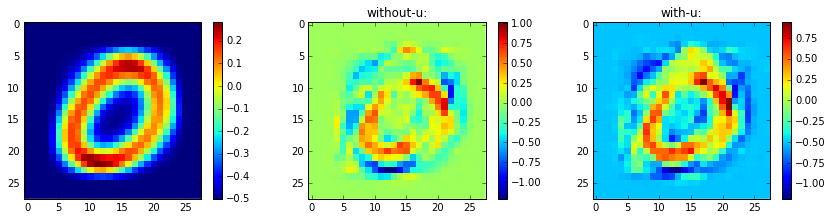

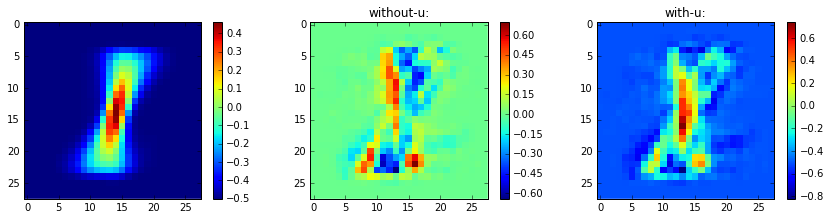

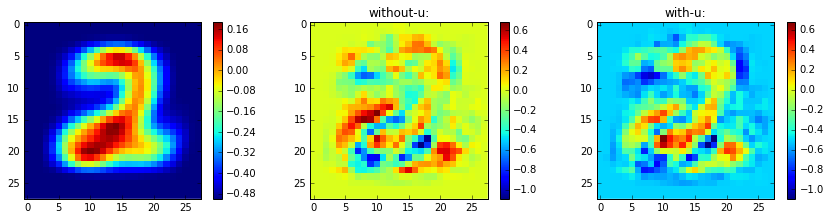

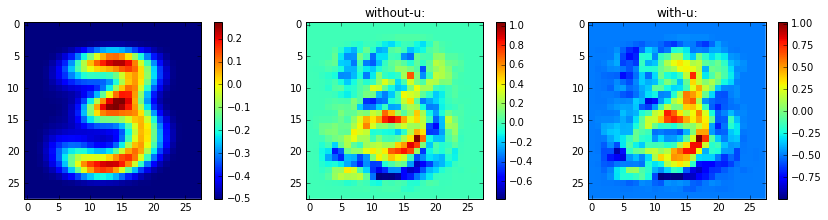

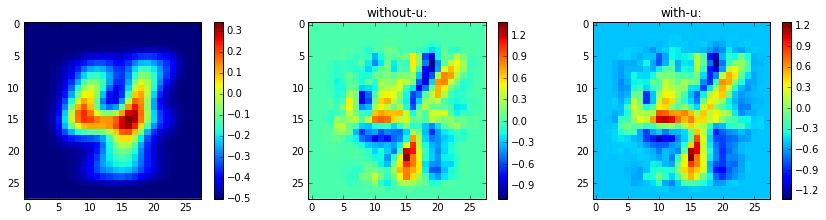

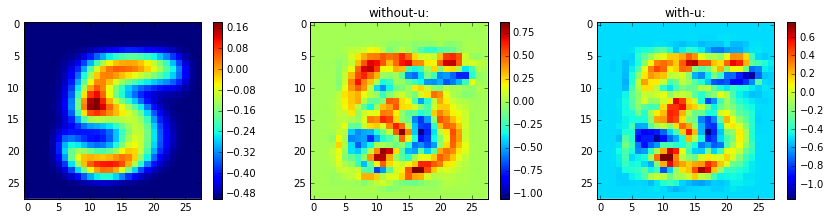

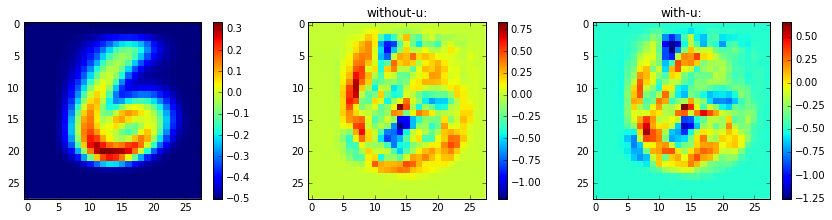

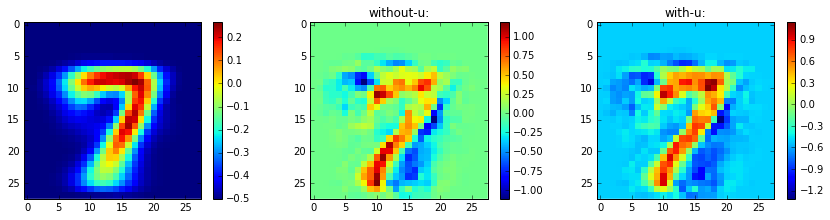

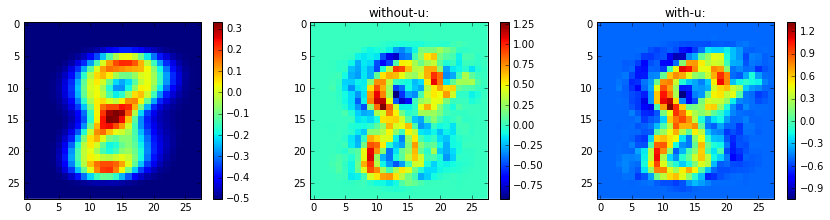

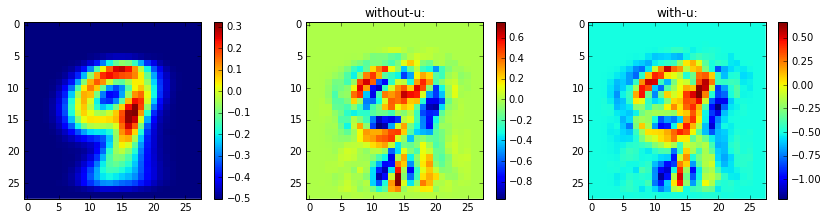

In [9]:
# Generate bigger images with colorbar from A and u

cols = 10
for i in range(10):
    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.imshow(centers[i].reshape(28, 28), interpolation="none")
    plt.colorbar()
    
    A = As[i]
    u = centers[i][:, None]

    x = np.random.standard_normal((784, 1))
    x = np.average(x, axis=1)
    x = x[:, None]

    plt.subplot(132)
    d = np.dot(A, x) # + u
    img = d.reshape((28, 28))
    plt.imshow(img, interpolation="none")
    plt.colorbar()
    plt.title("without-u:")
        
    plt.subplot(133)
    d = np.dot(A, x) + u
    img = d.reshape((28, 28))
    plt.imshow(img, interpolation="none")
    plt.colorbar()
    plt.title("with-u:")

    plt.tight_layout()
    plt.show()

# Generate probability distribution function

- Probability distribution function can be generated from A and centers
- Some tricks are necessary to avoid singularity of matrix A
 - Select only linearly independent rows (bases)
 - Use pseude-inverse matrix instead of inverse matrix
 - Scale pseudo-inverse of matrix A to avoid det=0 and/or det=inf

i= 0  n= 4955
z0 : shape= (784, 4955) min= -0.785365 max= 0.999798 mean= 2.70141e-07 std= 0.252655 rank= 520 


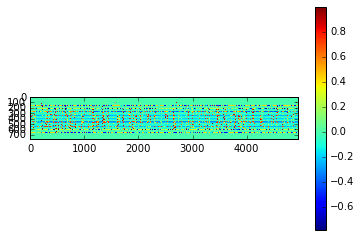

cov : shape= (784, 784) min= -0.120548 max= 0.197069 mean= 0.00181056 std= 0.01616 rank= 415 det= 0.0


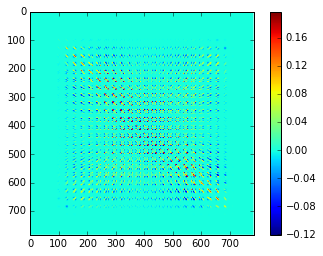

A : shape= (784, 784) min= -0.0589088 max= 0.279156 mean= 0.000995493 std= 0.0089683 rank= 527 det= -0.0


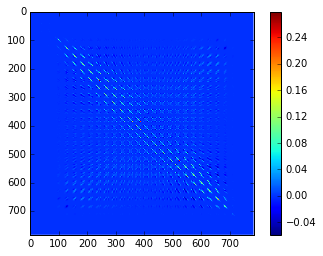

max(abs(A * A.T - cov))= 1.78814e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 96 max= 0.0570666
B : shape= (784, 407) min= -0.0589088 max= 0.279156 mean= 0.00189286 std= 0.012365 rank= 407 


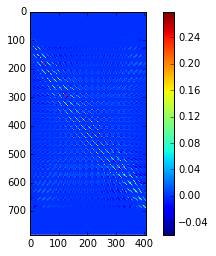

BPI : shape= (407, 784) min= -12.1604 max= 26.7276 mean= 0.0020087 std= 0.501502 rank= 407 


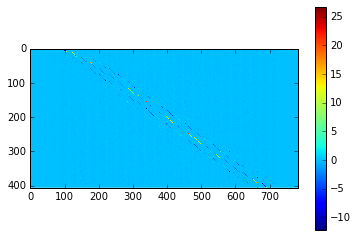

BPI : shape= (407, 784) min= -1.42599 max= 3.13421 mean= 0.00023555 std= 0.0588086 rank= 407 


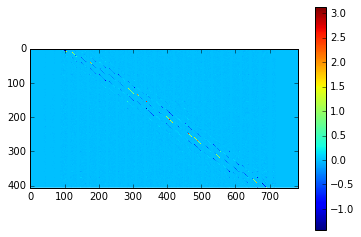

x : shape= (407, 4955) min= -1.99222 max= 4.02106 mean= 9.78461e-09 std= 0.118706 rank= 407 


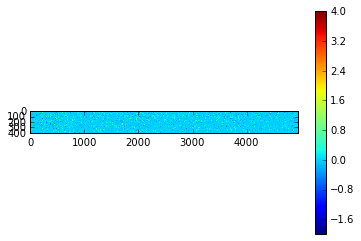

d : shape= (4955,) min= 2.1995 max= 32.4698 mean= 5.73505 std= 2.5157 rank= 1 
p : shape= (4955,) min= 4.62091707743e-230 max= 0.0355132901537 mean= 0.000668225827633 std= 0.00239436300031 rank= 1 
i= 1  n= 5649
z0 : shape= (784, 5649) min= -0.964928 max= 0.999659 mean= -6.96663e-08 std= 0.169644 rank= 474 


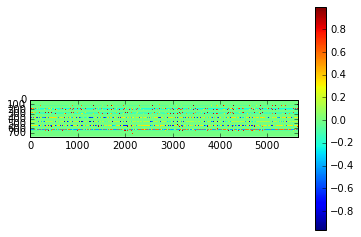

cov : shape= (784, 784) min= -0.131593 max= 0.199833 mean= 0.000486891 std= 0.0113572 rank= 274 det= 0.0


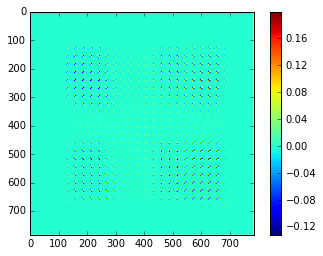

A : shape= (784, 784) min= -0.0446484 max= 0.259968 mean= 0.000427252 std= 0.00604362 rank= 508 det= 0.0


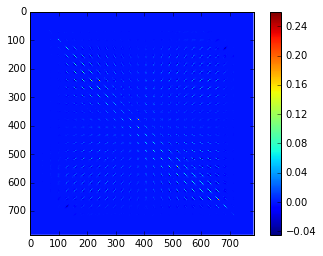

max(abs(A * A.T - cov))= 1.04308e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 98 max= 0.0518122
B : shape= (784, 244) min= -0.0446484 max= 0.259968 mean= 0.00122676 std= 0.0107221 rank= 244 


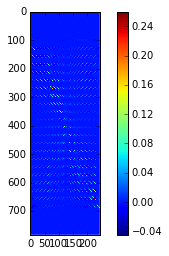

BPI : shape= (244, 784) min= -13.0815 max= 28.9004 mean= 0.00370974 std= 0.632838 rank= 244 


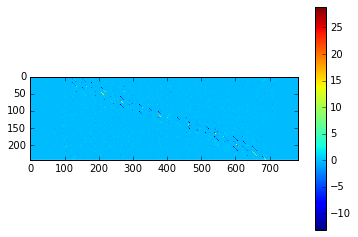

BPI : shape= (244, 784) min= -1.23219 max= 2.72223 mean= 0.000349434 std= 0.0596093 rank= 244 


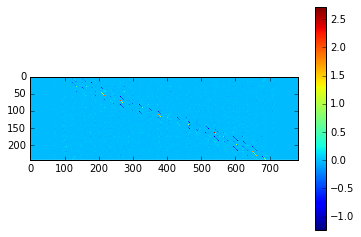

x : shape= (244, 5649) min= -1.88579 max= 2.90214 mean= -1.00501e-07 std= 0.0989965 rank= 244 


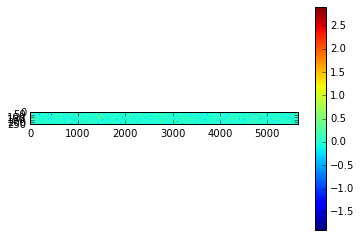

d : shape= (5649,) min= 0.334435 max= 41.2414 mean= 2.39127 std= 2.83872 rank= 1 
p : shape= (5649,) min= 0.0 max= 0.377244495094 mean= 0.136045757988 std= 0.110715570509 rank= 1 
i= 2  n= 4977
z0 : shape= (784, 4977) min= -0.688857 max= 0.999799 mean= 1.1322e-07 std= 0.254589 rank= 574 


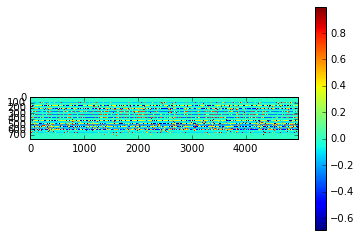

cov : shape= (784, 784) min= -0.11149 max= 0.199398 mean= 0.00146158 std= 0.0125346 rank= 477 det= 0.0


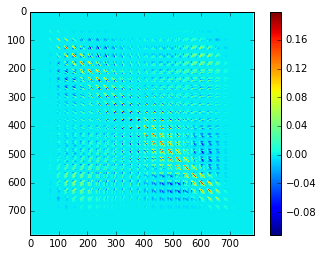

A : shape= (784, 784) min= -0.0523296 max= 0.283359 mean= 0.000919942 std= 0.00904579 rank= 584 det= -0.0


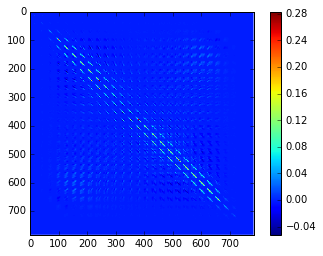

max(abs(A * A.T - cov))= 2.08616e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 66 max= 0.0542596
B : shape= (784, 457) min= -0.0523296 max= 0.283359 mean= 0.00155957 std= 0.0117928 rank= 457 


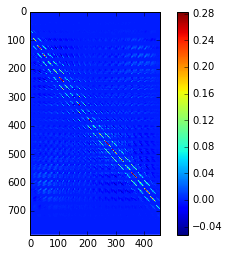

BPI : shape= (457, 784) min= -14.693 max= 31.8874 mean= 0.00267797 std= 0.563398 rank= 457 


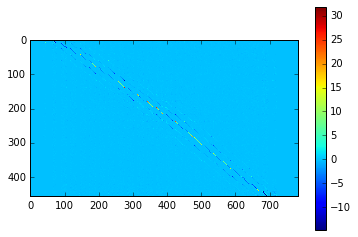

BPI : shape= (457, 784) min= -1.71423 max= 3.72031 mean= 0.000312439 std= 0.0657317 rank= 457 


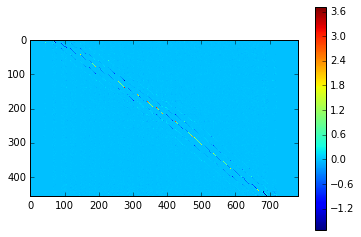

x : shape= (457, 4977) min= -2.05781 max= 3.26404 mean= -1.72675e-09 std= 0.118516 rank= 457 


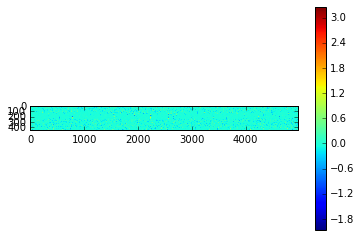

d : shape= (4977,) min= 2.34133 max= 26.8516 mean= 6.41905 std= 2.66256 rank= 1 
p : shape= (4977,) min= 1.08698676173e-157 max= 0.0257361701312 mean= 0.000179317150516 std= 0.000978401521213 rank= 1 
i= 3  n= 5129
z0 : shape= (784, 5129) min= -0.774729 max= 0.999609 mean= 1.04485e-07 std= 0.239916 rank= 549 


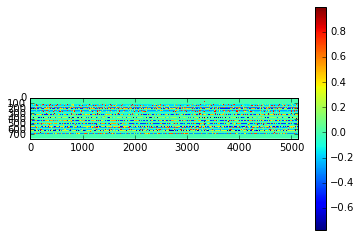

cov : shape= (784, 784) min= -0.114131 max= 0.193089 mean= 0.00146453 std= 0.0117872 rank= 451 det= 0.0


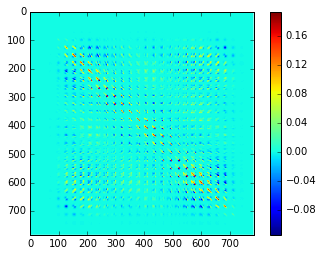

A : shape= (784, 784) min= -0.0544926 max= 0.289738 mean= 0.000896904 std= 0.00852135 rank= 558 det= 0.0


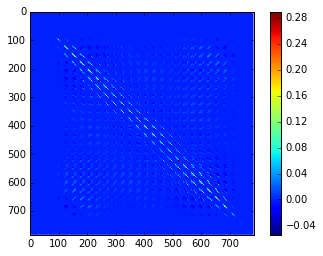

max(abs(A * A.T - cov))= 2.08616e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 94 max= 0.0580256
B : shape= (784, 429) min= -0.0544926 max= 0.289738 mean= 0.00161211 std= 0.0114514 rank= 429 


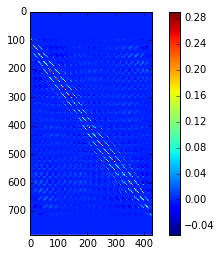

BPI : shape= (429, 784) min= -14.2623 max= 30.7824 mean= 0.00270811 std= 0.550595 rank= 429 


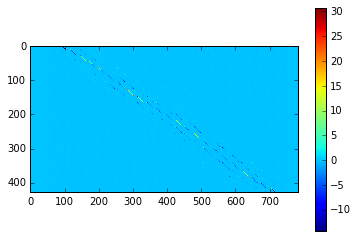

BPI : shape= (429, 784) min= -1.64646 max= 3.55357 mean= 0.000312629 std= 0.0635615 rank= 429 


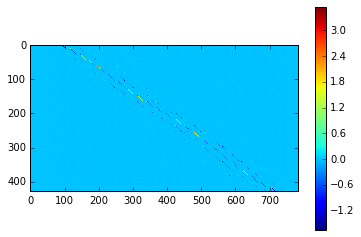

x : shape= (429, 5129) min= -2.25029 max= 3.20941 mean= 7.12674e-09 std= 0.117813 rank= 429 


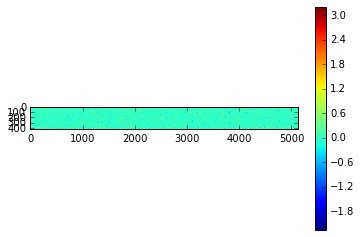

d : shape= (5129,) min= 2.13151 max= 34.6884 mean= 5.9545 std= 2.94143 rank= 1 
p : shape= (5129,) min= 2.04555042498e-262 max= 0.0411471159463 mean= 0.000899717688297 std= 0.00302510859299 rank= 1 
i= 4  n= 4808
z0 : shape= (784, 4808) min= -0.843628 max= 0.999724 mean= -9.7511e-09 std= 0.228808 rank= 556 


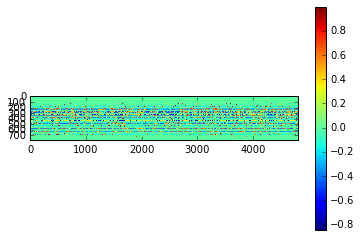

cov : shape= (784, 784) min= -0.110217 max= 0.192718 mean= 0.00102147 std= 0.0107976 rank= 457 det= 0.0


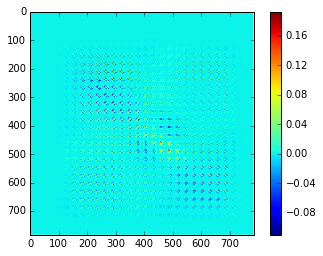

A : shape= (784, 784) min= -0.0543453 max= 0.284618 mean= 0.000740883 std= 0.00813805 rank= 561 det= 0.0


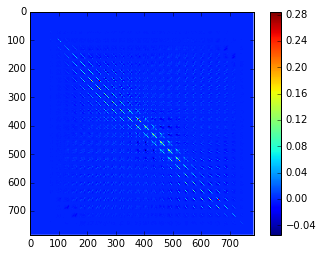

max(abs(A * A.T - cov))= 1.49012e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 103 max= 0.0502294
B : shape= (784, 415) min= -0.0543453 max= 0.284618 mean= 0.0013626 std= 0.0111213 rank= 415 


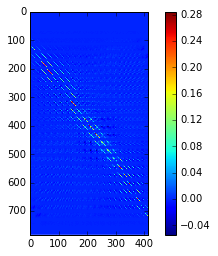

BPI : shape= (415, 784) min= -17.2633 max= 38.2172 mean= 0.0033204 std= 0.566312 rank= 415 


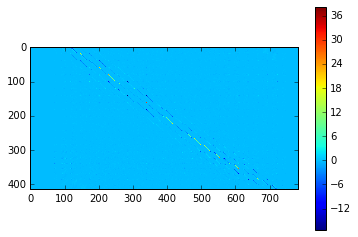

BPI : shape= (415, 784) min= -1.92165 max= 4.25413 mean= 0.000369608 std= 0.0630387 rank= 415 


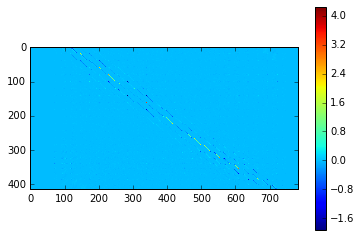

x : shape= (415, 4808) min= -2.0284 max= 2.84049 mean= -2.85776e-08 std= 0.113828 rank= 415 


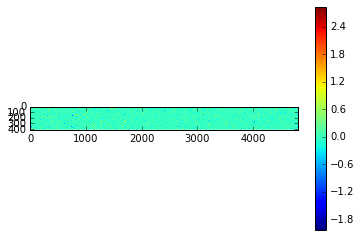

d : shape= (4808,) min= 1.62809 max= 45.4091 mean= 5.37712 std= 2.98876 rank= 1 
p : shape= (4808,) min= 0.0 max= 0.106003443965 mean= 0.00257774090487 std= 0.00740027892796 rank= 1 
i= 5  n= 4529
z0 : shape= (784, 4529) min= -0.683379 max= 0.999779 mean= 2.03953e-08 std= 0.246391 rank= 557 


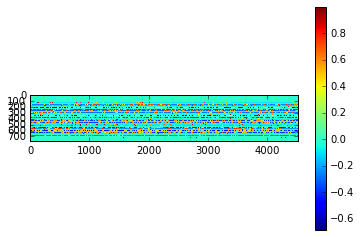

cov : shape= (784, 784) min= -0.100656 max= 0.192863 mean= 0.00137638 std= 0.0138306 rank= 441 det= 0.0


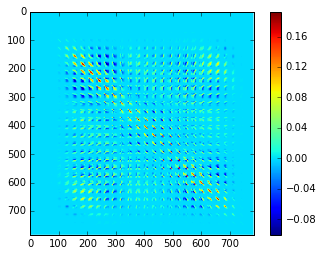

A : shape= (784, 784) min= -0.0475469 max= 0.29081 mean= 0.000873354 std= 0.00875624 rank= 562 det= 0.0


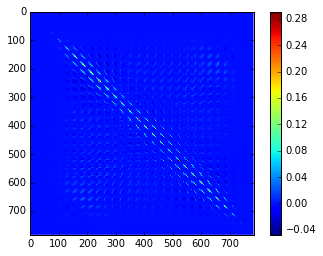

max(abs(A * A.T - cov))= 1.49012e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 98 max= 0.0557244
B : shape= (784, 429) min= -0.0475469 max= 0.29081 mean= 0.00156083 std= 0.0117699 rank= 429 


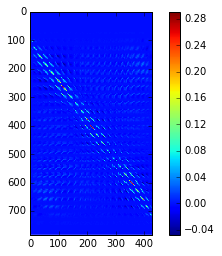

BPI : shape= (429, 784) min= -16.6172 max= 34.6447 mean= 0.00249375 std= 0.58793 rank= 429 


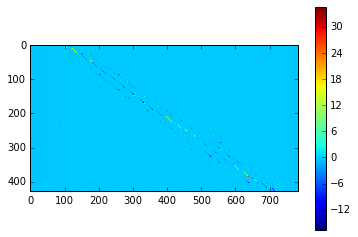

BPI : shape= (429, 784) min= -1.87809 max= 3.91557 mean= 0.000281845 std= 0.0664484 rank= 429 


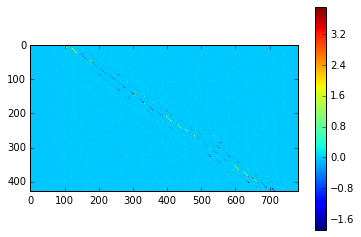

x : shape= (429, 4529) min= -2.38517 max= 3.1693 mean= -6.41087e-09 std= 0.115774 rank= 429 


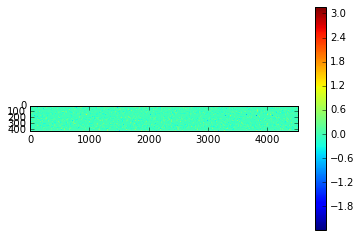

d : shape= (4529,) min= 1.80986 max= 30.698 mean= 5.75016 std= 3.12158 rank= 1 
p : shape= (4529,) min= 9.29215321251e-206 max= 0.0775570410795 mean= 0.000800460593493 std= 0.00300495285122 rank= 1 
i= 6  n= 4935
z0 : shape= (784, 4935) min= -0.833507 max= 0.999265 mean= 5.01161e-08 std= 0.235424 rank= 522 


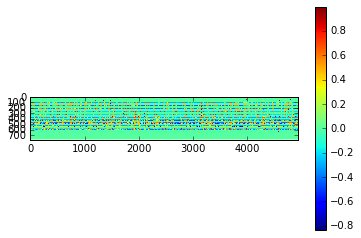

cov : shape= (784, 784) min= -0.108423 max= 0.192206 mean= 0.00142758 std= 0.0132607 rank= 405 det= 0.0


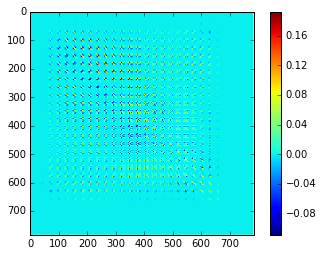

A : shape= (784, 784) min= -0.0496574 max= 0.296692 mean= 0.000849208 std= 0.00836501 rank= 530 det= 0.0


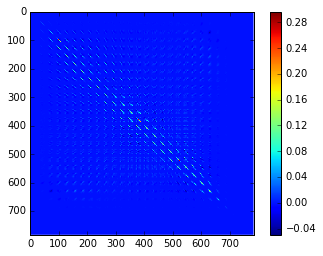

max(abs(A * A.T - cov))= 2.38419e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 39 max= 0.0513899
B : shape= (784, 397) min= -0.0496574 max= 0.296692 mean= 0.00163766 std= 0.0116765 rank= 397 


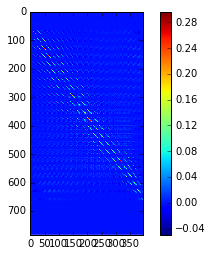

BPI : shape= (397, 784) min= -17.9373 max= 40.3235 mean= 0.0029972 std= 0.61398 rank= 397 


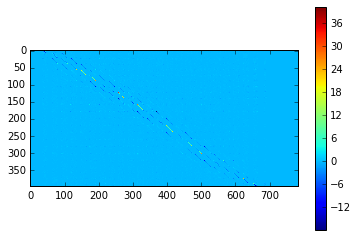

BPI : shape= (397, 784) min= -1.92428 max= 4.32583 mean= 0.000321534 std= 0.0658666 rank= 397 


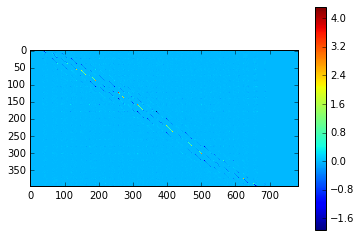

x : shape= (397, 4935) min= -1.61883 max= 3.53709 mean= -4.99936e-09 std= 0.11016 rank= 397 


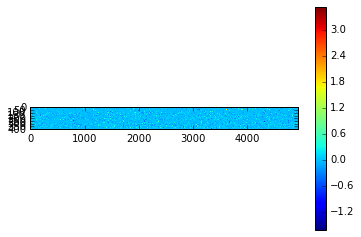

d : shape= (4935,) min= 1.24974 max= 34.9956 mean= 4.81771 std= 3.31129 rank= 1 
p : shape= (4935,) min= 4.59612580182e-267 max= 0.182708802637 mean= 0.00968900241405 std= 0.0190427341704 rank= 1 
i= 7  n= 5152
z0 : shape= (784, 5152) min= -0.768204 max= 0.999464 mean= 9.19791e-08 std= 0.218813 rank= 547 


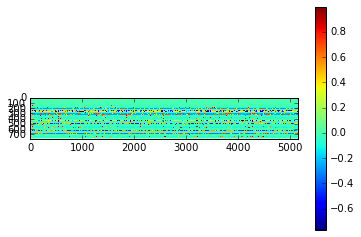

cov : shape= (784, 784) min= -0.111844 max= 0.194368 mean= 0.000966832 std= 0.0114936 rank= 427 det= 0.0


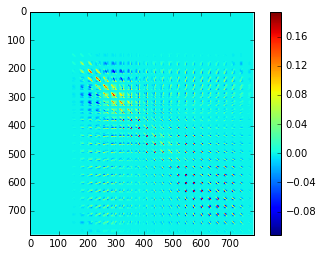

A : shape= (784, 784) min= -0.0500622 max= 0.276111 mean= 0.000703264 std= 0.00778305 rank= 555 det= 0.0


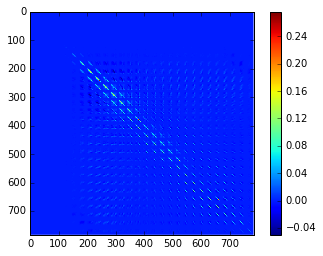

max(abs(A * A.T - cov))= 2.08616e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 148 max= 0.0506375
B : shape= (784, 399) min= -0.0500622 max= 0.276111 mean= 0.00133892 std= 0.0108417 rank= 399 


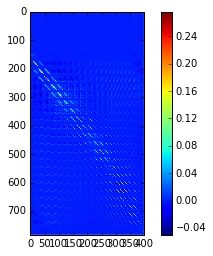

BPI : shape= (399, 784) min= -20.6301 max= 41.6568 mean= 0.00335377 std= 0.614069 rank= 399 


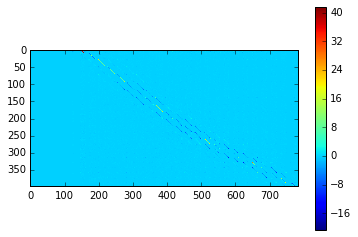

BPI : shape= (399, 784) min= -2.1202 max= 4.28116 mean= 0.000344674 std= 0.0631093 rank= 399 


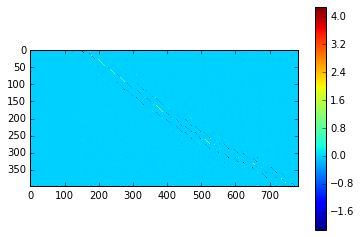

x : shape= (399, 5152) min= -2.16871 max= 2.79304 mean= -1.09172e-08 std= 0.105917 rank= 399 


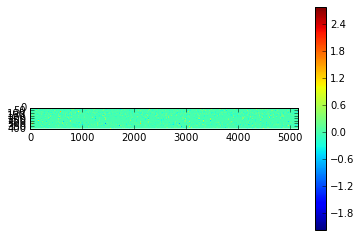

d : shape= (5152,) min= 1.13193 max= 37.5017 mean= 4.47614 std= 3.0051 rank= 1 
p : shape= (5152,) min= 1.61886296443e-306 max= 0.21022705766 mean= 0.0176340779089 std= 0.0329628182081 rank= 1 
i= 8  n= 4895
z0 : shape= (784, 4895) min= -0.832828 max= 0.999367 mean= 9.96814e-08 std= 0.241697 rank= 531 


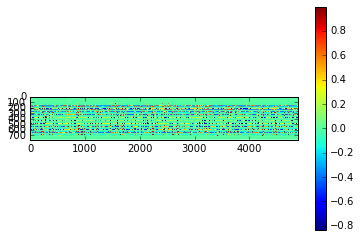

cov : shape= (784, 784) min= -0.0891943 max= 0.189584 mean= 0.00149825 std= 0.0112441 rank= 429 det= 0.0


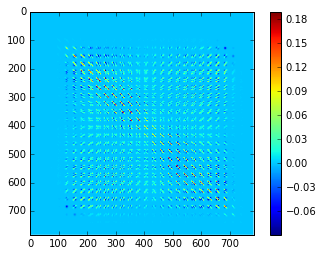

A : shape= (784, 784) min= -0.0502592 max= 0.306122 mean= 0.000913072 std= 0.00858363 rank= 541 det= 0.0


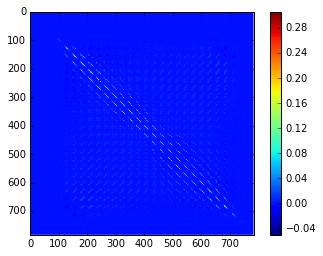

max(abs(A * A.T - cov))= 1.93715e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 122 max= 0.0659713
B : shape= (784, 402) min= -0.0502592 max= 0.306122 mean= 0.00174315 std= 0.0119029 rank= 402 


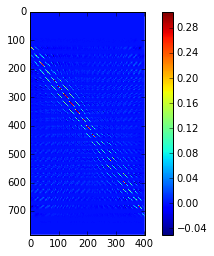

BPI : shape= (402, 784) min= -17.3228 max= 38.8409 mean= 0.00236425 std= 0.55204 rank= 402 


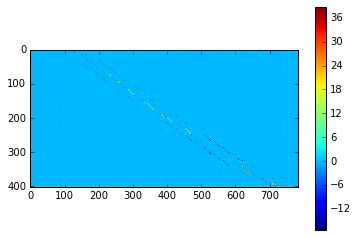

BPI : shape= (402, 784) min= -2.14689 max= 4.81373 mean= 0.000293011 std= 0.0684168 rank= 402 


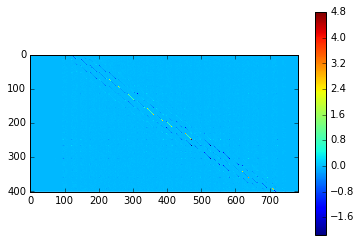

x : shape= (402, 4895) min= -2.25227 max= 3.28591 mean= 7.27291e-09 std= 0.126874 rank= 402 


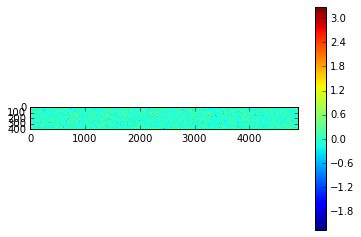

d : shape= (4895,) min= 1.9505 max= 39.6219 mean= 6.47095 std= 4.00494 rank= 1 
p : shape= (4895,) min= 0.0 max= 0.059536163948 mean= 0.000955500836337 std= 0.00330148642012 rank= 1 
i= 9  n= 4971
z0 : shape= (784, 4971) min= -0.823722 max= 0.999658 mean= 4.01715e-08 std= 0.222221 rank= 511 


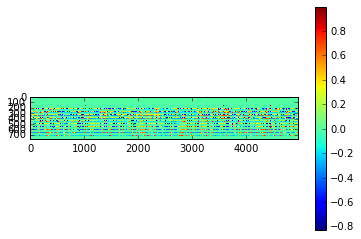

cov : shape= (784, 784) min= -0.110919 max= 0.1922 mean= 0.00107512 std= 0.0114912 rank= 391 det= 0.0


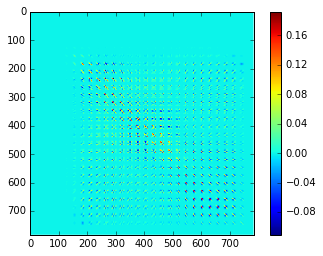

A : shape= (784, 784) min= -0.0621173 max= 0.300081 mean= 0.000741092 std= 0.00790177 rank= 523 det= -0.0


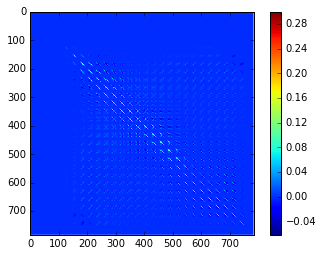

max(abs(A * A.T - cov))= 1.49012e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 151 max= 0.0654191
B : shape= (784, 371) min= -0.0621173 max= 0.300081 mean= 0.00150289 std= 0.0114036 rank= 371 


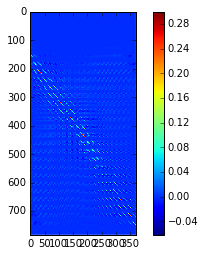

BPI : shape= (371, 784) min= -15.6278 max= 35.2387 mean= 0.00281735 std= 0.633792 rank= 371 


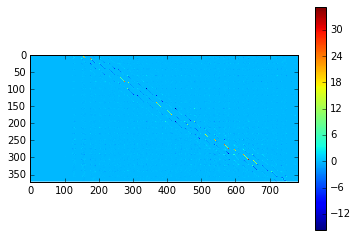

BPI : shape= (371, 784) min= -1.6625 max= 3.74872 mean= 0.000299712 std= 0.0674233 rank= 371 


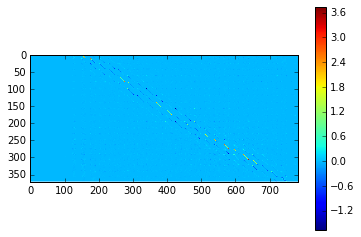

x : shape= (371, 4971) min= -2.29095 max= 3.49211 mean= -1.28852e-08 std= 0.110547 rank= 371 


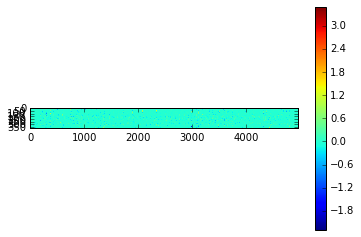

d : shape= (4971,) min= 1.18666 max= 44.2741 mean= 4.53386 std= 3.8767 rank= 1 
p : shape= (4971,) min= 0.0 max= 0.197301333258 mean= 0.0164862096972 std= 0.0272793129989 rank= 1 


In [10]:
# Calculate probability for each image in image-cluster using Variance-covariance matrix

covs = []
As = []
Bs = []
bindexes = []
BPIs = []
ps = []
for i in range(10):
    z = x_sample_of_chars[i]
    n = len(z)
    z = z.T
    u = centers[i]
    print("i=", i, " n=", n)
    
    z0 = z - u[:, None]
    print_stat(z0, "z0")
#    d0 = np.sum(z0 * z0, axis=0)
#    print_stat(d0, "d0")
    
    # Calculate Variance-covariance matrix cov
    cov = np.dot(z0, z0.T)/n
    print_stat(cov, "cov")
    covs.append(cov)

    # Calculate A s.t. A * A.T = cov
    U, s, V = np.linalg.svd(cov, full_matrices=False)
    r = np.sqrt(s)
    A = np.dot(np.dot(U, np.diag(r)), V)
    print_stat(A, "A")
    As.append(A)

    # check if A * A.T = cov
    print("max(abs(A * A.T - cov))=", np.max(np.max(np.dot(A, A.T) - cov)))
    
    # extract only base rows
    B, index, rank = extract_base(A, 0.05)
#    B = B[index,:]
    print_stat(B, "B")
    Bs.append(B)
    bindexes.append(index)
    
    # extract only base rows
#    z0 = z0[index, :]
#    print_stat(z0, "z0")
    
    # calculate pseudo-inverse of B
    BPI = np.linalg.pinv(B)
    print_stat(BPI, "BPI")
    
    # scale BPI to avoid det=0 and/or det=inf
    U, s, V = np.linalg.svd(BPI, full_matrices=False)
    s = s / scipy.stats.mstats.gmean(s)
    BPI = np.dot(np.dot(U, np.diag(s)), V)
    print_stat(BPI, "BPI")
    BPIs.append(BPI)

    x = np.dot(BPI, z0)
    print_stat(x, "x")

    d = np.sum(x * x, axis=0)
    print_stat(d, "d")

    p = scipy.stats.norm.pdf(d)
    print_stat(p, "p")
    ps.append(p)


i= 0 min= 7.12457640675e-218  max= 0.0355132901537
i= 1 min= 7.12457640674e-218  max= 0.377244495094
i= 2 min= 1.08698676173e-157  max= 0.0257361701312
i= 3 min= 7.12457640674e-218  max= 0.0411471159463
i= 4 min= 7.12457640674e-218  max= 0.106003443965
i= 5 min= 9.29215321252e-206  max= 0.0775570410795
i= 6 min= 7.12457640674e-218  max= 0.182708802637
i= 7 min= 7.12457640674e-218  max= 0.21022705766
i= 8 min= 7.12457640674e-218  max= 0.059536163948
i= 9 min= 7.12457640674e-218  max= 0.197301333258


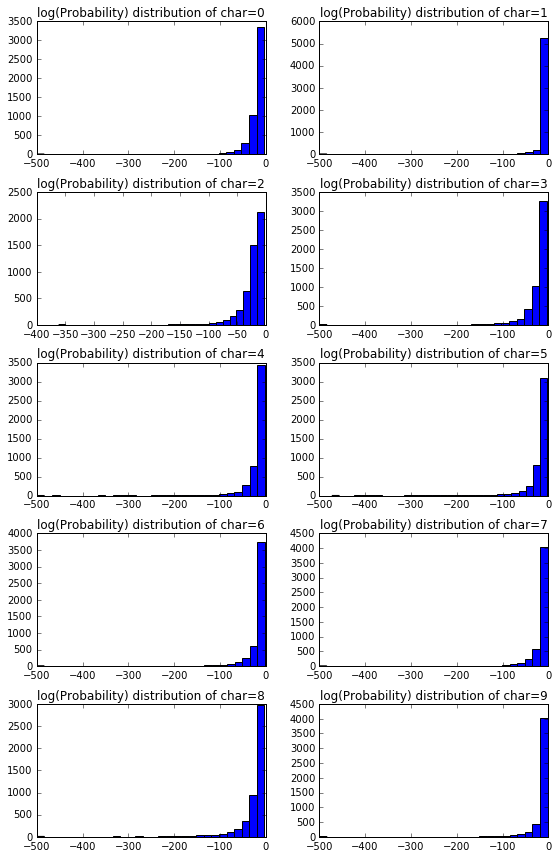

In [11]:
# Display histgrom of log(probability) in each image-cluster

plt.figure(figsize=(8, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    p = ps[i] + np.exp(-500)
    print("i=", i ,"min=", np.min(p), " max=", np.max(p))
    plt.hist(np.log(p), bins=30)
#    plt.hist(p)
    plt.title("log(Probability) distribution of char="+str(i))
plt.tight_layout()
plt.show()

#  Check if each image-cluster is seperated by pdf
* pdf: probability distribution function

In [12]:
# Calculate ratio of data in cluster of which nearest center is its center
# Result: x% (x% - x%) of cluster member are nearest from the center

far_xs = []
nearest_centers = []
total_count = 0
total_ok_count = 0
for i in range(10):
  xi = x_sample_of_chars[i] 
 
  n = len(xi)
  z = xi.T
  pi = ps[i]
  i_is_nearest = np.ones(n)
  nearest_center  = np.ones(n, dtype=np.int) * i
  nearest_p = np.copy(pi)

  for j in range(10):
    if i == j:
      continue
    
    u = centers[j]
    z0 = z - u[:, None]

    BPI = BPIs[j]
    x = np.dot(BPI, z0)
    d = np.sum(x * x, axis=0)
    pj = scipy.stats.norm.pdf(d)
    
    i_is_near = (pi > pj).astype(np.int)
    i_is_nearest  = i_is_nearest  * i_is_near
    
    j_is_near = nearest_p < pj
    nearest_p[j_is_near] = pj[j_is_near]
    nearest_center[j_is_near] = j
    
  i_is_far = (np.ones_like(i_is_nearest) - i_is_nearest).astype(np.bool)
  far_x = x_sample_of_chars[i][i_is_far]
  far_xs.append(far_x)
  nearest_centers.append(nearest_center[i_is_far])
    
  ok_count  = np.sum(i_is_nearest )
  ok_ratio  = ok_count/n
  ng_count  = n - ok_count
  ng_ratio  = ng_count/n
  print("{}: ok={:.0f}({:.1f}%), ng={:.0f}({:.1f}%)".format(
        i, ok_count, ok_ratio*100, ng_count, ng_ratio*100))
  total_count += n
  total_ok_count += ok_count

total_ok_ratio = total_ok_count / total_count
total_ng_count = total_count - total_ok_count
total_ng_ratio = total_ng_count / total_count
print("OK={:.0f}/{:.0f}({:.1f}%), NG={:.0f}/{:.0f}({:.1f}%)".format(
      total_ok_count, total_count, total_ok_ratio*100, total_ng_count, total_count, total_ng_ratio*100))

0: ok=4842(97.7%), ng=113(2.3%)
1: ok=5152(91.2%), ng=497(8.8%)
2: ok=4814(96.7%), ng=163(3.3%)
3: ok=4747(92.6%), ng=382(7.4%)
4: ok=4639(96.5%), ng=169(3.5%)
5: ok=4202(92.8%), ng=327(7.2%)
6: ok=4689(95.0%), ng=246(5.0%)
7: ok=4801(93.2%), ng=351(6.8%)
8: ok=4573(93.4%), ng=322(6.6%)
9: ok=4522(91.0%), ng=449(9.0%)
OK=46981/50000(94.0%), NG=3019/50000(6.0%)


# of far data for char 0 = 113
# of far data for char 1 = 497
# of far data for char 2 = 163
# of far data for char 3 = 382
# of far data for char 4 = 169
# of far data for char 5 = 327
# of far data for char 6 = 246
# of far data for char 7 = 351
# of far data for char 8 = 322
# of far data for char 9 = 449


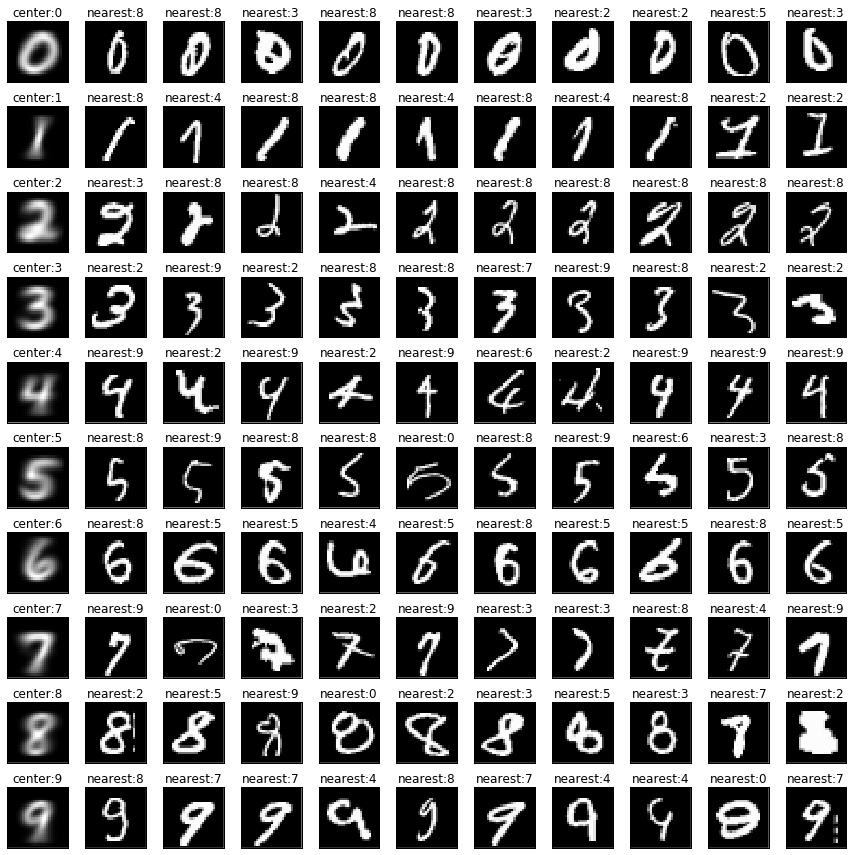

In [13]:
# Generate images far from center

cols = 10
offset = 0
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(10, (cols + 1), (cols + 1)*i + 1)
    plt.imshow(centers[i].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title("center:"+str(i))
    plt.xticks([])
    plt.yticks([])

    len_far_i = len(far_xs[i])
    print("# of far data for char {} = {}".format(i, len_far_i))
    for j in range(offset, min(offset + cols, len_far_i)):
      plt.subplot(10, (cols + 1), (cols + 1)*i + j + 2)
      plt.imshow(far_xs[i][j].reshape(28, 28), cmap="gray", interpolation="none")
      plt.title("nearest:" + str(nearest_centers[i][j]))
      plt.xticks([])
      plt.yticks([])
plt.tight_layout()

# Try Classification of test data

In [14]:
# get test data

num_all_sample = 10000
x_sample, y_sample = mnist.test.next_batch(num_all_sample)

# shift and scale x_sample [0,1.0] => [-0.5, 0.5]
x_sample = (x_sample - 0.5) * 1.0

x_sample_of_chars = []
for char in range(10):
    index = np.arange(num_all_sample)[y_sample[:,char] == 1]
    x_sample_of_char = x_sample[index]
    x_sample_of_chars.append(x_sample_of_char)

In [15]:
# Calculate ratio of data in cluster of which nearest center is its center
# Result: x% (x% - x%) of cluster member are nearest from the center

far_xs = []
nearest_centers = []
total_count = 0
total_ok_count = 0
for i in range(10):
  xi = x_sample_of_chars[i] 
 
  n = len(xi)
  z = xi.T
#  pi = ps[i]

  u = centers[i]
  z0 = z - u[:, None]

  BPI = BPIs[i]
  x = np.dot(BPI, z0)
  d = np.sum(x * x, axis=0)
  pi = scipy.stats.norm.pdf(d)

  i_is_nearest = np.ones(n)
  nearest_center  = np.ones(n, dtype=np.int) * i
  nearest_p = np.copy(pi)

  for j in range(10):
    if i == j:
      continue
    
    u = centers[j]
    z0 = z - u[:, None]

    BPI = BPIs[j]
    x = np.dot(BPI, z0)
    d = np.sum(x * x, axis=0)
    pj = scipy.stats.norm.pdf(d)
    
    i_is_near = (pi > pj).astype(np.int)
    i_is_nearest  = i_is_nearest  * i_is_near
    
    j_is_near = nearest_p < pj
    nearest_p[j_is_near] = pj[j_is_near]
    nearest_center[j_is_near] = j
    
  i_is_far = (np.ones_like(i_is_nearest) - i_is_nearest).astype(np.bool)
  far_x = x_sample_of_chars[i][i_is_far]
  far_xs.append(far_x)
  nearest_centers.append(nearest_center[i_is_far])
    
  ok_count  = np.sum(i_is_nearest )
  ok_ratio  = ok_count/n
  ng_count  = n - ok_count
  ng_ratio  = ng_count/n
  print("{}: ok={:.0f}({:.1f}%), ng={:.0f}({:.1f}%)".format(
        i, ok_count, ok_ratio*100, ng_count, ng_ratio*100))
  total_count += n
  total_ok_count += ok_count

total_ok_ratio = total_ok_count / total_count
total_ng_count = total_count - total_ok_count
total_ng_ratio = total_ng_count / total_count
print("OK={:.0f}/{:.0f}({:.1f}%), NG={:.0f}/{:.0f}({:.1f}%)".format(
      total_ok_count, total_count, total_ok_ratio*100, total_ng_count, total_count, total_ng_ratio*100))

0: ok=952(97.1%), ng=28(2.9%)
1: ok=1027(90.5%), ng=108(9.5%)
2: ok=977(94.7%), ng=55(5.3%)
3: ok=907(89.8%), ng=103(10.2%)
4: ok=938(95.5%), ng=44(4.5%)
5: ok=799(89.6%), ng=93(10.4%)
6: ok=879(91.8%), ng=79(8.2%)
7: ok=922(89.7%), ng=106(10.3%)
8: ok=873(89.6%), ng=101(10.4%)
9: ok=887(87.9%), ng=122(12.1%)
OK=9161/10000(91.6%), NG=839/10000(8.4%)


Takayoshi Iitsuka 2016/10/5 
mail: iitt21-t@yahoo.co.jp